D'abord on va entrainer un classificateur des images en utilisant le dataset FashionMinst .


Préparer les données :

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader= torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

L'architecture du classificateur

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4) #flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

State pour enregistrer l'état de modele lors de l'entrainement :

In [ ]:
class State:
    def __init__(self, model, optim):
        self.model = model
        self.optimizer = optim
        self.epoch, self.iteration = 0, 0

itération d'entraînement :

In [ ]:
def train_loop(dataloader, model, optimizer):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        yhat = model(X)
        L = nn.CrossEntropyLoss()
        loss = L(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, pred = torch.max(yhat, 1)
        train_acc += (torch.sum( pred == y) / dataloader.batch_size).item()
    return train_loss / len(dataloader), train_acc / len(dataloader)

itération de test :

In [ ]:
def test_loop(dataloader, model):
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            yhat = model(X)
            L = nn.CrossEntropyLoss()
            loss = L(yhat, y)
            test_loss += loss.item()
            _, pred = torch.max(yhat, 1)
            test_acc += (torch.sum( pred == y) / dataloader.batch_size).item()
    return test_loss / len(dataloader), test_acc / len(dataloader)

la fonction d'entraînement de modèle

In [ ]:
def train(data_train, data_test, save_path, Model, tensorboard_name, iterations=500):
    if save_path.is_file():
        with save_path.open('rb') as fp:
            state = torch.load(fp)
    else :
        model = Model()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        state = State(model, optimizer)
    for epoch in range(state.epoch, iterations):
        loss_train, acc_train = train_loop(data_train, state.model, state.optimizer)
        with save_path.open("wb") as fp:
            state.epoch = epoch + 1
            torch.save(state, fp)
        loss_test, acc_test = test_loop(data_test, state.model)
        writer.add_scalar(tensorboard_name+'/train', loss_train, epoch)
        writer.add_scalar(tensorboard_name+'/test', loss_test, epoch)         
        print('Epoch:', epoch , 'Loss train: ',loss_train, ' Acc train: ', acc_train,'Loss test: ',loss_test, ' Acc test: ', acc_test, '\n\n')
    print("Done!")
    return state.model

In [ ]:
from pathlib import Path
import datetime

savepath1 = Path('./model.pt')
writer = SummaryWriter("runs/runs"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model1 = train(trainloader, testloader, savepath1, Classifier, "Classifier" ,iterations=10)

Done!


**Perturbations :**

nous allons maintenant procéder à la perturbation du modèle entrainé.

Fonction de projection :

Pour s'assurer que la contrainte ≤ ξ est satisfaite, la perturbation universelle actualisée est en outre projetée sur la boule lp de rayon xi et centrée sur 0.

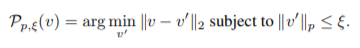


In [ ]:
import numpy as np

def project_lp(v, xi, p):
    if p == 2:
        v = v * min(1, xi / np.linalg.norm(v.flatten(1)))
    elif p == np.inf:
        v = np.sign(v) * np.minimum(abs(v), xi)
    return v

Fooling rate :

Plusieurs passages sur l'ensemble de données X sont effectués pour améliorer la qualité de la perturbation universelle. L'algorithme s'arrête lorsque le "fooling_rate" sur l'ensemble de données perturbé dépasse le seuil cible 1 - δ. 


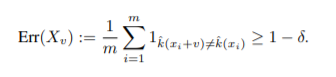

In [ ]:
batch_size = 32
def get_fooling_rate(dataloader,v,model):    
    fooled=0.0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        _, pred = torch.max(model(X),1)
        _, pert_pred = torch.max(model(X+v),1)
        for i in range(len(pred)):
          if(pred[i]!=pert_pred[i]):
              fooled+=1
    fooling_rate = fooled/(len(dataloader)*batch_size)
    return fooling_rate

fonction qui trouve la perturbation minimale ∆vi qui envoie le point perturbé actuel, xi+v, à la frontière de décision du classifieur :

In [ ]:
#temporaire jusqu'a trouver une solution plus efficace

def minimal_perturbation (x , classifier , v , max_iterations) :
  x = torch.stack([x])
  yhat = classifier(x)
  _,ki = torch.max(yhat,1)
  label = ki[0]
  iter = 0
  step = torch.full((1,1,28, 28), 1e-4).to(device) 
  r = torch.full((1,1,28, 28), 1e-4).to(device)
  while ki == label  and iter < max_iterations:
    tmp = x + v + r
    tmp = tmp.float()
    _,ki = torch.max(classifier(tmp),1)
    r += step
    iter+=1
  return r , iter < max_iterations

Fonction de génération de perturbations :

In [ ]:
def perturbation (dataloader , classifier , xi , delta , max_iterations ,max_iterations_min) :
  v=torch.zeros([1,1,28,28])
  fooling_rate = 0.0
  iter = 0

  while fooling_rate < 1-delta and iter < max_iterations:
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            _, pred = torch.max(classifier(X),1)
            _, pert_pred = torch.max(classifier(X),1)
            for i in range(len(pred)) :
              if(pred[i]==pert_pred[i]):
                  dr , b = minimal_perturbation (X[i] , classifier , v , max_iterations_min)
                  if b :
                    v = project_lp(v + dr,xi,np.inf)  
        fooling_rate= get_fooling_rate(dataloader,v,classifier)
        print(fooling_rate)
        iter = iter + 1   
  return v , fooling_rate

In [ ]:
v , fooling_rate = perturbation (trainloader , model1 , 10 , 0.2 , 10 ,10)

In [ ]:
print("fooling rate obtenu est " , fooling_rate)

In [ ]:
import matplotlib.pyplot as plt

def show_image(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Afficher quelque images et ses labels avant perturbation :

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:5]
_, labels = torch.max(model1(images),1)
show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

Afficher les memes images et ses labels aprés perturbation :

In [ ]:
pert_images = torch.zeros(images.shape)
for i in range(len(images)) :
  pert_images[i] = images[i] + v[0]
_, pert_labels = torch.max(model1(pert_images),1)

In [ ]:
show_image(torchvision.utils.make_grid(pert_images))
print(' '.join('%5s' % classes[pert_labels[j]] for j in range(5)))